###  Imports

In [1]:
item_list = ['american flag', 'person', 'astronaut', 'helmet', 'basket ball', 'baseball glove', 'space shuttle', 'camera', 'train', 'UH-1 Huey', 'T-72 tank', 'football helmet', 'soccer ball', 'baseball bat', 'tennis racket', ' tennis ball', 'cleats', 'boxing gloves', 'man reading a newspaper', 'bike', 'baby sitting in a swing', 'football', 'tree', 'sea turtle', 'fish', 'kanye west', 'airplane', 'car', 'steph curry', 'michael jordan', 'green grass', 'little girl']

image_dir = r'./test_images'

WEIGHTS_NAME='CLIP-RPN_rpn_full_training epoch_1.pth'

loaded checkpoint at epoch 1


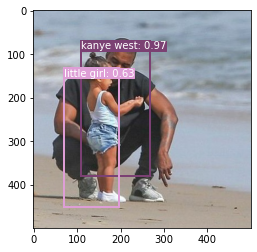

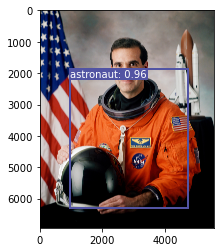

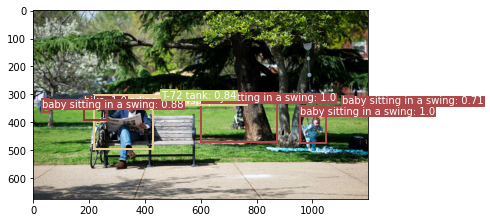

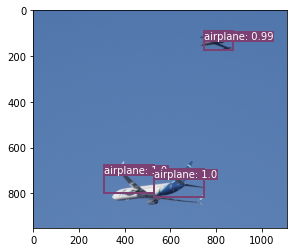

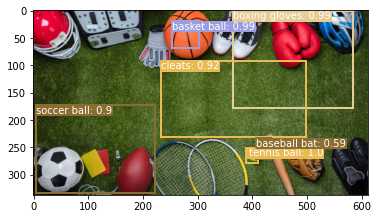

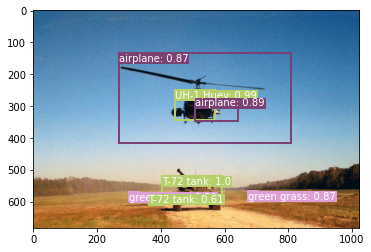

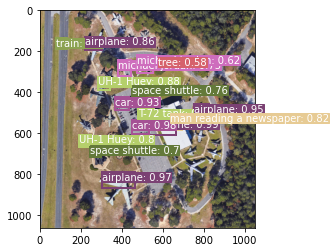

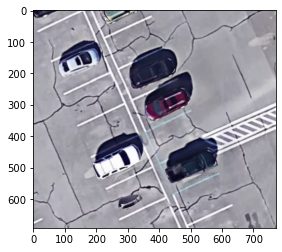

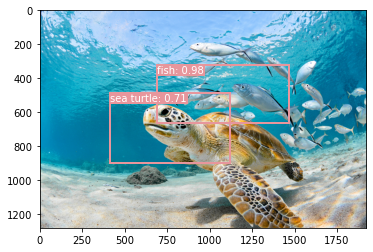

In [4]:
from evaluation import eval
#args:
#     rpn_score_thresh = minimum threshold objectness score. default: 0.05
#     iou_thresh = minimum overlap to be considered the same object. default: 0.2
#     conf_thresh = minimum classification confidence. default: 0.9
#     item_list = list of classes
#     WEIGHTS_NAME = the subname of thw weights file
#     MODEL_EPOCH = epoch of trained model
#     EPS = a parameter of DBSCAN
#     Pred_clustering = uses custom clustering pior to NMS

eval(item_list, rpn_score_thresh = .05, iou_thresh=.2, conf_thresh=.5, MODEL_TYPE = 'CLIP-RPN', WEIGHTS_NAME=WEIGHTS_NAME, image_dir=image_dir, PRED_CLUSTERING=True, weighted_bboxes=True, eps=30)

loaded checkpoint at epoch 1


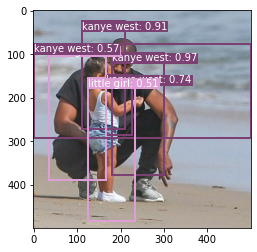

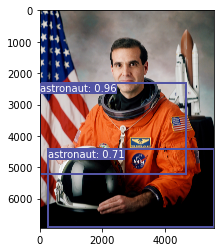

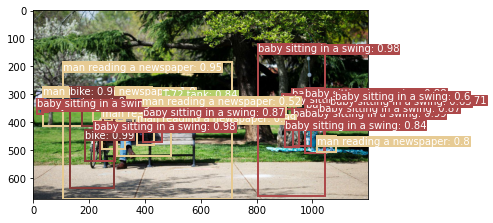

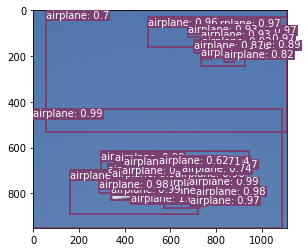

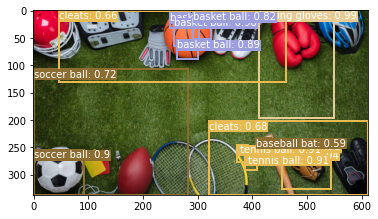

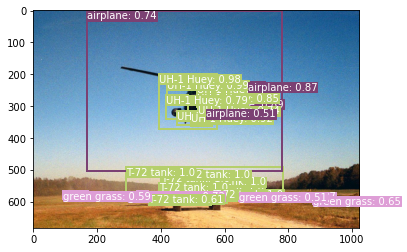

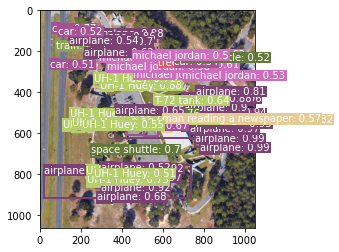

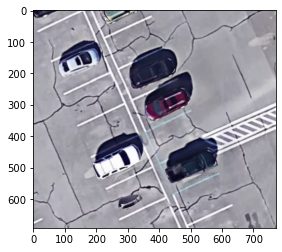

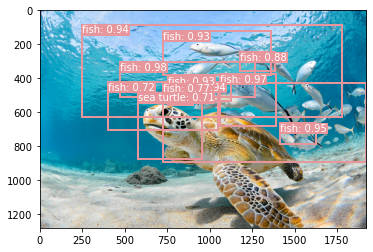

In [3]:
eval(item_list, rpn_score_thresh = .05, iou_thresh=.2, conf_thresh=.5, MODEL_TYPE = 'CLIP-RPN', WEIGHTS_NAME=WEIGHTS_NAME, image_dir=image_dir, PRED_CLUSTERING=False, weighted_bboxes=True, eps=30)